In [1]:
#import decision regression tools:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text
import plotly.express as px
import config

In [2]:
# create database engine
db_url = f"postgresql://{config.DB_USERNAME}:{config.DB_PASSWORD}@{config.DB_HOST}/{config.DB_NAME}"
engine = create_engine(db_url)

/Users/ericdally/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# load all the data into a datafame by joining the tables
query = text('''
Select * 
FROM "RawRecords" as r
JOIN "CalculatedStats" AS cs ON cs."RecordId"=r."Id";
''')
df = pd.read_sql_query(query,con=engine)
df.set_index('Id', inplace=True)
df

,State,Year,Enrolled,TotalRevenue,FederalRevenue,StateRevenue,LocalRevenue,TotalExpenditure,InstructionExpenditure,SupportServicesExpenditure,...,AvgMath4Score,AvgMath8Score,AvgReading4Score,AvgReading8Score,RecordId,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent
Id,,,,,,,,,,,,,,,,,,,,,
2003_ALABAMA,ALABAMA,2003,727900.0,5196054.0,567704.0,2966981.0,1661369.0,5298932.0,2817111.0,1521462.0,...,223.0,262.0,207.0,253.0,2003_ALABAMA,0.109257,0.571007,0.319737,7.138417,0.542164
2003_ALASKA,ALASKA,2003,133303.0,1425948.0,259423.0,813371.0,353154.0,1610289.0,763525.0,514052.0,...,233.0,279.0,212.0,256.0,2003_ALASKA,0.181930,0.570407,0.247663,10.697044,0.535451
2003_ARIZONA,ARIZONA,2003,875111.0,6529894.0,740579.0,2912629.0,2876686.0,6210287.0,2810907.0,1964229.0,...,229.0,271.0,209.0,255.0,2003_ARIZONA,0.113414,0.446045,0.440541,7.461789,0.430467
2003_ARKANSAS,ARKANSAS,2003,450158.0,3241275.0,379947.0,2394336.0,466992.0,3242799.0,1768713.0,972598.0,...,229.0,266.0,214.0,258.0,2003_ARKANSAS,0.117221,0.738702,0.144077,7.200305,0.545684
2003_CALIFORNIA,CALIFORNIA,2003,6226552.0,59815855.0,5795655.0,33617766.0,20402434.0,59749885.0,29561563.0,17030335.0,...,227.0,267.0,206.0,251.0,2003_CALIFORNIA,0.096892,0.562021,0.341087,9.606578,0.494209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015_VIRGINIA,VIRGINIA,2015,1279867.0,15857524.0,1012205.0,6240349.0,8604970.0,16113212.0,8755896.0,5075509.0,...,247.0,288.0,229.0,267.0,2015_VIRGINIA,0.063831,0.393526,0.542643,12.389978,0.552160
2015_WASHINGTON,WASHINGTON,2015,1072359.0,13709442.0,1036422.0,8293812.0,4379208.0,13630138.0,6508964.0,4510672.0,...,245.0,287.0,226.0,267.0,2015_WASHINGTON,0.075599,0.604971,0.319430,12.784377,0.474780
2015_WEST_VIRGINIA,WEST_VIRGINIA,2015,279565.0,3478401.0,362959.0,1979466.0,1135976.0,3466981.0,1819903.0,1161944.0,...,235.0,271.0,216.0,260.0,2015_WEST_VIRGINIA,0.104347,0.569074,0.326580,12.442191,0.523201


## Tweaking Database

In [4]:
model_df = df[[
    "AvgMath4Score",
    "AvgMath8Score",
    "AvgReading4Score",
    "AvgReading8Score",
    "FederalFundingPercent",
    "StateFundingPercent",
    "LocalFundingPercent",
    "RevenuePerStudent",
    "InstructionalExpensePercent"
]]
model_df.index = df.index
model_df

,AvgMath4Score,AvgMath8Score,AvgReading4Score,AvgReading8Score,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent
Id,,,,,,,,,
2003_ALABAMA,223.0,262.0,207.0,253.0,0.109257,0.571007,0.319737,7.138417,0.542164
2003_ALASKA,233.0,279.0,212.0,256.0,0.181930,0.570407,0.247663,10.697044,0.535451
2003_ARIZONA,229.0,271.0,209.0,255.0,0.113414,0.446045,0.440541,7.461789,0.430467
2003_ARKANSAS,229.0,266.0,214.0,258.0,0.117221,0.738702,0.144077,7.200305,0.545684
2003_CALIFORNIA,227.0,267.0,206.0,251.0,0.096892,0.562021,0.341087,9.606578,0.494209
...,...,...,...,...,...,...,...,...,...
2015_VIRGINIA,247.0,288.0,229.0,267.0,0.063831,0.393526,0.542643,12.389978,0.552160
2015_WASHINGTON,245.0,287.0,226.0,267.0,0.075599,0.604971,0.319430,12.784377,0.474780
2015_WEST_VIRGINIA,235.0,271.0,216.0,260.0,0.104347,0.569074,0.326580,12.442191,0.523201


In [5]:
#dropping DISTRICT_OF_COLUMBIA data
df = df.loc[df['State'] != 'DISTRICT_OF_COLUMBIA']
df.shape

(350, 22)

In [6]:
# combining grade scores
Avg_Score = (df.AvgMath4Score + df.AvgMath8Score + df.AvgReading4Score + df.AvgReading8Score)/4
df['Avg Score'] = Avg_Score
df.head()

/Users/ericdally/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,State,Year,Enrolled,TotalRevenue,FederalRevenue,StateRevenue,LocalRevenue,TotalExpenditure,InstructionExpenditure,SupportServicesExpenditure,...,AvgMath8Score,AvgReading4Score,AvgReading8Score,RecordId,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent,Avg Score
Id,,,,,,,,,,,,,,,,,,,,,
2003_ALABAMA,ALABAMA,2003,727900.0,5196054.0,567704.0,2966981.0,1661369.0,5298932.0,2817111.0,1521462.0,...,262.0,207.0,253.0,2003_ALABAMA,0.109257,0.571007,0.319737,7.138417,0.542164,236.25
2003_ALASKA,ALASKA,2003,133303.0,1425948.0,259423.0,813371.0,353154.0,1610289.0,763525.0,514052.0,...,279.0,212.0,256.0,2003_ALASKA,0.181930,0.570407,0.247663,10.697044,0.535451,245.00
2003_ARIZONA,ARIZONA,2003,875111.0,6529894.0,740579.0,2912629.0,2876686.0,6210287.0,2810907.0,1964229.0,...,271.0,209.0,255.0,2003_ARIZONA,0.113414,0.446045,0.440541,7.461789,0.430467,241.00
2003_ARKANSAS,ARKANSAS,2003,450158.0,3241275.0,379947.0,2394336.0,466992.0,3242799.0,1768713.0,972598.0,...,266.0,214.0,258.0,2003_ARKANSAS,0.117221,0.738702,0.144077,7.200305,0.545684,241.75
2003_CALIFORNIA,CALIFORNIA,2003,6226552.0,59815855.0,5795655.0,33617766.0,20402434.0,59749885.0,29561563.0,17030335.0,...,267.0,206.0,251.0,2003_CALIFORNIA,0.096892,0.562021,0.341087,9.606578,0.494209,237.75


# Linear Regression for Local Funding

In [7]:
# Defining variables
X = df[["LocalFundingPercent"]]
y = df['Avg Score']

In [8]:
#Creating regression object
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [9]:
#Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
y_prediction =  regr.predict(X_test)

In [11]:
#Comparing the Test Set with Predicted Values
df_L = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_prediction})
df_L.head()

,Real Values,Predicted Values
Id,,
2013_MARYLAND,259.50,253.092560
2015_NORTH_DAKOTA,256.25,249.755925
2007_TEXAS,252.25,253.917835
2011_RHODE_ISLAND,253.00,254.038652
2007_FLORIDA,250.75,253.374862


In [12]:
df_L.shape

(70, 2)

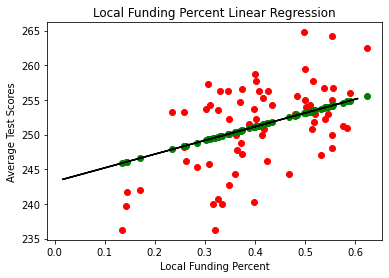

In [13]:
# plotting the results
plt.scatter(X_test, y_test, color = 'red')
plt.scatter(X_test, y_prediction, color = 'green')
plt.plot(X_train, regr.predict(X_train), color = 'black')
plt.title('Local Funding Percent Linear Regression')
plt.xlabel('Local Funding Percent')
plt.ylabel('Average Test Scores')
plt.show()

#Note: Real values are in Red, Predicted values are in green, and the Regression line is in black

In [14]:
# Testing accuracy of model:
from sklearn.metrics import mean_squared_error, r2_score

# predicting the accuracy score
score=mean_squared_error(y_test,y_prediction)

print(f'The Mean Squared Error is {score}')

The Mean Squared Error is 28.28864899895318


In [15]:
#Calculating Standard Error
Grade_Point_Error = (abs(df_L['Predicted Values'] - df_L['Real Values'])/df_L['Real Values'])*100
print(f' Uncertainty of Grade Points is +/- {sum(Grade_Point_Error)/70} Percent')

 Uncertainty of Grade Points is +/- 1.7193234908207158 Percent


In [16]:
Grade_Point_Error.shape

(70,)

In [17]:
print(X_test, y_prediction)

                    LocalFundingPercent
Id                                     
2013_MARYLAND                  0.498934
2015_NORTH_DAKOTA              0.330421
2007_TEXAS                     0.540614
2011_RHODE_ISLAND              0.546716
2007_FLORIDA                   0.513192
...                                 ...
2003_WEST_VIRGINIA             0.284416
2009_KANSAS                    0.346365
2007_NEW_MEXICO                0.142973
2015_KANSAS                    0.258464
2013_INDIANA                   0.306720

[70 rows x 1 columns] [253.09256009 249.75592509 253.91783533 254.03865173 253.37486193
 251.426384   251.14486769 253.43578873 251.4799073  254.1649606
 255.5562511  251.29220315 254.23472086 253.13332516 249.54437402
 251.1052591  254.60460486 249.68568309 249.84881069 248.38916409
 250.8816941  250.55888428 249.32324143 250.42609071 253.10798268
 254.87402662 252.75098473 250.57611091 253.31070661 253.46726467
 251.45620696 253.51265502 254.16891138 246.57532801 250.63688

In [18]:
#Picking two points of the regression line: 

#One: (0.341087, 249.96712671) 
#two: (0.509877, 253.3092186)

#slope = (y2 - y1)/(x2 - x1)

#y intercept = y - mx, where m is the slope (y = mx+b),

slope = (253.3092186 - 249.96712671)/(0.509877 - 0.341087)

y_intercept = 253.3092186 - slope*0.509877


print(f'slope = {slope}, Y intercept = {y_intercept}')

slope = 19.8002955743824, Y intercept = 243.21350329342064


## Linear regression Function (Local Funding Percent): y = 19.8002955743824*x + 243.21350329342064

In [19]:
#Function of Linear reqression is y = 19.8002955743824*x + 243.21350329342064

#f(0.2) = 247.17356240829712
#f(0.3) = 249.15359196573536

#Increase = 1.98002955743824

#Uncertainty = Increase*Grade_Point_Error Percent = 1.98002955743824*.01992830955634046 = 0.0394586419513330

#Meaning, if you increase local funding by 10 percent, NAEP test scores will go up, on average, 
# 2 grade points +/- 0.04 points

# Linear Regression for Revenue Per Student

In [22]:
# Defining variables
X1 = df[["RevenuePerStudent"]]
y1 = df['Avg Score']

In [23]:
#Creating regression object
regr = linear_model.LinearRegression()
regr.fit(X1, y1)

LinearRegression()

In [24]:
#Splitting the dataset into the Training set and Test set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2)

In [25]:
#Make Prediction
y1_prediction =  regr.predict(X1_test)

In [26]:
#Comparing the Test Set with Predicted Values
df_R = pd.DataFrame({'Real Values':y1_test, 'Predicted Values':y1_prediction})
df_R.head()

,Real Values,Predicted Values
Id,,
2015_TEXAS,251.75,250.632427
2009_NEW_HAMPSHIRE,260.75,253.306636
2011_FLORIDA,251.25,249.733509
2013_HAWAII,249.75,251.903251
2011_SOUTH_DAKOTA,255.25,249.982333


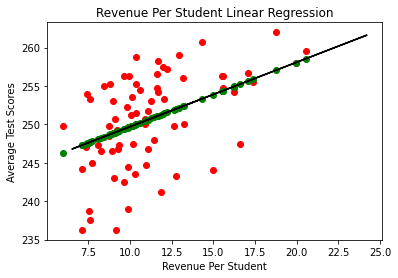

In [27]:
# plotting the results
plt.scatter(X1_test, y1_test, color = 'red')
plt.scatter(X1_test, y1_prediction, color = 'green')
plt.plot(X1_train, regr.predict(X1_train), color = 'black')
plt.title('Revenue Per Student Linear Regression')
plt.xlabel('Revenue Per Student')
plt.ylabel('Average Test Scores')
plt.show()

#Note: Real values are in Red, Predicted values are in green, and the Regression line is in black

In [28]:
# Testing accuracy of model:
from sklearn.metrics import mean_squared_error, r2_score

# predicting the accuracy score
score1=mean_squared_error(y1_test,y1_prediction)

print(f'The Mean Squared Error is {score1}')

The Mean Squared Error is 27.67968645444278


In [29]:
#Calculating Standard Error
Grade_Point_Error1 = (abs(df_R['Predicted Values'] - df_R['Real Values'])/df_R['Real Values'])*100
print(f' Uncertainty of Grade Points is +/- {sum(Grade_Point_Error1)/70} Percent')

 Uncertainty of Grade Points is +/- 1.6888216904737752 Percent


In [30]:
print(X1_test, y1_prediction)

                    RevenuePerStudent
Id                                   
2015_TEXAS                  11.105598
2009_NEW_HAMPSHIRE          14.293497
2011_FLORIDA                10.034006
2013_HAWAII                 12.620535
2011_SOUTH_DAKOTA           10.330627
...                               ...
2009_MINNESOTA              12.928800
2003_ALABAMA                 7.138417
2011_UTAH                    7.593126
2015_MAINE                  15.550296
2003_FLORIDA                 7.706801

[70 rows x 1 columns] [250.63242736 253.30663617 249.73350914 251.90325091 249.98233318
 247.50139224 248.93025954 249.16398325 247.53077334 249.60098053
 249.12278811 249.99659183 254.3876473  249.42430555 249.65619772
 250.20657893 248.08731912 248.98978323 248.39413204 248.90113501
 254.92979124 249.84185677 255.62119636 251.43114162 252.03825294
 250.60002165 255.89578793 252.41298244 248.84416464 253.88802129
 249.96239421 255.22248874 250.4429188  257.04710099 248.62262737
 247.67037883 252.367

In [32]:
#Picking two points of the regression line: 

#One1 (2015_TEXAS): (11.105598, 250.63242736) 
#two1 (2009_NEW_HAMPSHIRE): (14.293497, 253.30663617)

#slope1 = (y2 - y1)/(x2 - x1)

#y intercept1 = y - mx, where m is the slope (y = mx+b),

slope1 = (253.30663617 - 250.63242736)/(14.293497 - 11.105598)

y_intercept1 = 253.30663617 - slope1*14.293497


print(f'slope = {slope1}, Y intercept = {y_intercept1}')

slope = 0.8388624639613683, Y intercept = 241.31635805795557


## Linear regression Function (Revenue Per Student for) : y = 0.8388624639613683*x + 241.31635805795557

In [ ]:
#Function of Linear reqression is y = 10.8388624639613683*x + 241.31635805795557

#f(10) = 249.704982697569253
#f(11) = 250.5438451615306213

#Increase = 0.8388624639613683

#Uncertainty = Increase*Grade_Point_Error Percent = 0.8388624639613683*0.016888216904737752 = 0.014166891244622343

#Meaning, if you increase Revenue Per Student by 1 dollar, NAEP test scores will go up on average about
#1 grade point +/- 0.01 points